# Machine Learning Lab 4: Mini Project 2

In mini-project 2, you'll be employing machine learning techniques, such as **Linear Probability Models (LPM)** or **k-Nearest Neighbors (KNN)**, to improve the government's ability to identify tax-evading firms. By analyzing characteristics common among tax-evading firms, the government can predict tax evasion with lower error rates, enhancing the effectiveness of targeted audits. 

### Today's Lab: KNN

Today, we will be working with a dataset that looks at physico-chemical and sensorial characteristics of Red Wine. The data were taken from the [UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/datasets/wine+quality)

The *rows* are samples of red wine. Each wine sample has the following characteristics (*columns*):

* Fixed acidity
* Volatile acidity
* Citric acid
* Residual sugar
* Chlorides
* Free sulfur dioxide
* Total sulfur dioxide
* Density
* pH
* Sulphates
* Alcohol
* Quality (score between 0 and 10)

We will use these characteristics or "features" to predict the quality of wine using a **KNN model**.

**In this Lab we will**
* Read in and explore the wine dataset
* Perform basic data pre-processing and create a test/train split
* Build a KNN model and explore different values of k
* Implement Cross-Validation to find the best K
* Experiment with different cost functions


**After today's lab you should be**
* Comfortable implementing a KNN model with scikit learn
* Comfortable implementing k-fold cross validation to select k.
* Comfortable interpreting the results of a confusion matrix and explain why you might choose different performance metrics depending on the goal of your prediction task

### Part 1: Load and Explore Data

In [308]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

##### Load Data from CSV

NOTE: In the CSV file, you'll notice that the columns are actually separated by semi-colons (not commas), so we'll need to include that when we call pd.read_csv().

In [309]:
wine_data = pd.read_csv('winequality-red.csv', sep=';')
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


##### Distribution of the Target Class

We start by looking at the distribution of the target class. If the distribution of the target class is imbalanced (i.e., some classes are overrepresented while others are underrepresented or if the data is skewed), it can lead to models that are biased towards the more frequent classes. 

In [310]:
print(wine_data.groupby("quality").size())


quality
3     10
4     53
5    681
6    638
7    199
8     18
dtype: int64


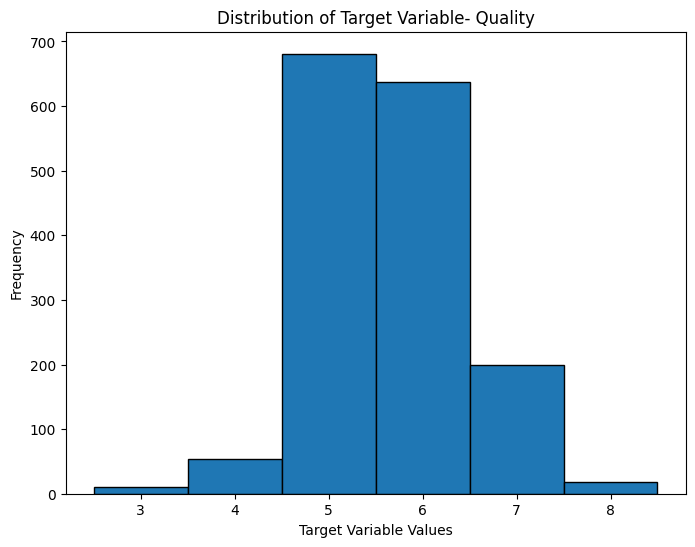

In [311]:
plt.figure(figsize=(8, 6))
plt.hist(wine_data['quality'], bins=[2.5, 3.5,4.5, 5.5, 6.5,7.5,8.5], edgecolor='black', alpha=1)
plt.xticks([3, 4, 5, 6, 7, 8])
plt.title('Distribution of Target Variable- Quality')
plt.xlabel('Target Variable Values')
plt.ylabel('Frequency')
plt.show()

##### Check for missing values

In [312]:
na_count = pd.DataFrame(np.sum(wine_data.isna(), axis = 0), columns = ["Count NAs"])
na_count

,Count NAs
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


##### Descriptive Statistics

In [313]:
pd.set_option('display.max_columns', None) # no column will be hidden in output
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### Part 2: Pre-processing 

##### Splitting Data

In [314]:
X = wine_data.drop(columns = ['quality'])
target = wine_data.loc[:,'quality']
display(X.head())
display(target.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

##### Check Data Types

The type of data will determine how you scale/normalize.

In [315]:
X.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
dtype: object

All of the data are floats so we can use the standard scalar which works by:

* Centering the Data: The process ensures that each feature has a mean of 0.

* Normalizing the Scale: Scales the data so that the features have a standard deviation of 1. 

*Why might be want to scale our values before model building?*

##### Scale Data

In [316]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
cols = X.columns
X_final = pd.DataFrame(X_scaled, columns=cols)
X_final.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246


##### Recode `Quality`

We will record `quality` such as a binary variable such that it is good if quality is greater than 6 and bad otherwise.

In [317]:
target = pd.DataFrame(np.where(target > 6, 1, 0)).squeeze()
target.head()

0    0
1    0
2    0
3    0
4    0
Name: 0, dtype: int64

Let's look again at the target variable distribution:

In [318]:
target.value_counts()

0    1382
1     217
Name: 0, dtype: int64

*What do we notice about the distribution of our target?*

##### Train/Test Split

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.20, random_state=42)

*Why do we hold out a separate test set?*

### Part 3: KNN

K-Nearest Neighbors (KNN) algorithm assumes that similar things exist in close proximity, i.e., "near things are more related than distant things." An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common k nearest neighbors.

EXAMPLE: When k=1, then the object is simply assigned to the class of that single nearest neighbor.

##### Let's try with k = 1...

In [320]:
knn_1 = KNeighborsClassifier(n_neighbors = 1)
knn_1.fit(X_train, y_train)
knn_1_pred = knn_1.predict(X_test)
accuracy_score(y_test, knn_1_pred)

0.853125

##### Confusion Matrix where k = 1

In [321]:
cm_knn1 = confusion_matrix(y_test, knn_1_pred)
cm_knn1_norm = confusion_matrix(y_test, knn_1_pred, normalize = 'true')
print(cm_knn1)
print(cm_knn1_norm)


[[251  22]
 [ 25  22]]
[[0.91941392 0.08058608]
 [0.53191489 0.46808511]]


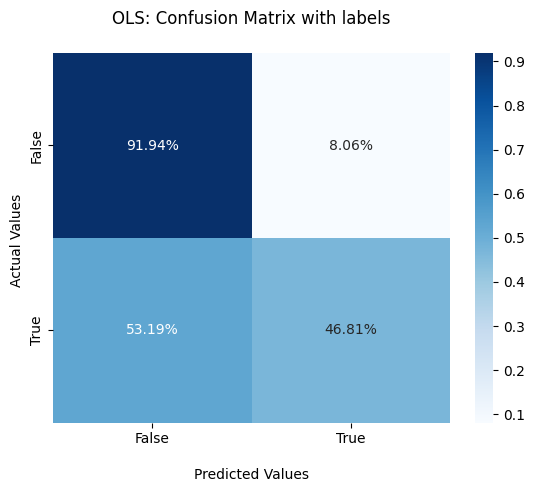

In [322]:
ax = sns.heatmap(cm_knn1_norm, annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('OLS: Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Interpretation

- True Negatives (TN) - 251 negative instances correctly classified as negative. (92% of actual negative instances correctly identified)
- False Positives (FP) - 22 negative instances incorrectly classified as positive. (8% of all actual negative instances that were incorrectly labeled as positive)
- False Negatives (FN) - 25 positive instances incorrectly classified as negative. (53% actual positive instances that were incorrectly labeled as negative)
- True Positives (TP) - 22 positive instances correctly classified as positive (47% of actual positive instances correctly identified)


##### Now lets try with k = 11...

In [323]:
knn_11 = KNeighborsClassifier(n_neighbors = 11)
knn_11.fit(X_train, y_train)
knn_11_pred = knn_11.predict(X_test)
accuracy_score(y_test, knn_11_pred)

0.85

Accuracy is higher, but lets dig in a little deeper:

In [324]:
cm_knn11 = confusion_matrix(y_test, knn_11_pred)
cm_knn11_norm = confusion_matrix(y_test, knn_11_pred, normalize = 'true')
print(cm_knn11)
print(cm_knn11_norm)

[[268   5]
 [ 43   4]]
[[0.98168498 0.01831502]
 [0.91489362 0.08510638]]


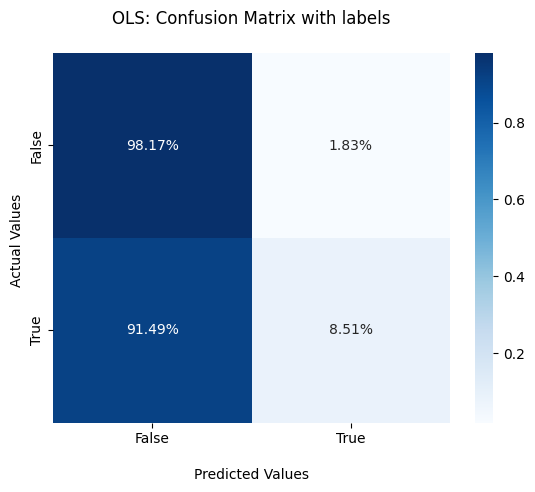

In [325]:
ax = sns.heatmap(cm_knn11_norm, annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('OLS: Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

*What do we notice about the results when k = 11?* *What might be conclude about this value of k given these results?*

#### Part 4: Finding the best k with cross-validation

Choosing the correct value of k is important. If k is too small, we risk over-fitting and if k is too high, we risk over-fitting. k-fold cross-validation is one way to choose the optimal k.

*Cross Validation:* Method to avoid over-fitting, especially when dataset is small. Dataset is divided into k subsets and trained on k−1 folds and then tested on the remaining part to validate the model performance. This process is repeated each time with a different fold held out for testing, and the rest used for training. The model's performance is then averaged over the k trials to provide a more comprehensive evaluation.

In [326]:
ks = list(range(1, 35))  #upper bound of k is roughly the square-root of the number of samples in our training set

para = {'n_neighbors': ks}

# Initialize the KNN classifier
knni = KNeighborsClassifier()

# Set up 5-fold cross-validation scheme
knn_cv = GridSearchCV(knni, para, cv=KFold(5, random_state=42, shuffle=True))

# Fit the model
knn_cv.fit(X_train, y_train)

print("Best parameters:", knn_cv.best_params_)
print("Best cross-validation score:", knn_cv.best_score_)


Best parameters: {'n_neighbors': 2}
Best cross-validation score: 0.8811458333333334


##### How might our results have changed if we defined 'good' wine differently?

In [327]:
target = wine_data.loc[:,'quality']
new_target = pd.DataFrame(np.where(target > 4, 1, 0)).squeeze()
X_train, X_test, y_train, y_test = train_test_split(X, new_target, test_size=0.20, random_state=42)

knn_cv.fit(X_train, y_train)
print("Best parameters:", knn_cv.best_params_)
print("Best cross-validation score:", knn_cv.best_score_)

Best parameters: {'n_neighbors': 9}
Best cross-validation score: 0.959344362745098


Distribution of Target Class

In [328]:
display(new_target.value_counts())

1    1536
0      63
Name: 0, dtype: int64

In [329]:
knn_9 = KNeighborsClassifier(n_neighbors = 9)
knn_9.fit(X_train, y_train)
knn_9_pred = knn_9.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, knn_9_pred))

Accuracy Score: 0.965625


Confusion Matrix

In [330]:
cm_knn9 = confusion_matrix(y_test, knn_9_pred)
cm_knn9_norm = confusion_matrix(y_test, knn_9_pred, normalize = 'true')
print(cm_knn9)
print(cm_knn9_norm)

[[  0  11]
 [  0 309]]
[[0. 1.]
 [0. 1.]]


### Part 5: Changing the Performance Metric

Above, we used *accuracy* as our performance metric. **Accuracy** measures the proportion of true results (both true positives and true negatives) among the total number of cases examined.

However, depending on the nature of our data and the goal of our task, we may want to evaluate our model on different metrics.

Let's say we are really concerned with not classifying bad wine as good wine. That is to say, we are most concerned with minimizing false positives.

For example, we might use **precision** instead of **accuracy**. Precision measures the proportion of true positive predictions in all positive predictions made by the model. High precision means that the model is reliable in its positive predictions.

In [331]:
precision_scores = []

for i in ks:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    precision = precision_score(y_test, pred_i, zero_division=0)
    precision_scores.append(precision)

precision_scores = np.array(precision_scores)
max_precision = max(precision_scores)
opt_k_precision = ks[np.argmax(precision_scores)]

print("Optimal k for maximum precision:", opt_k_precision)
print("Maximum precision:", max_precision)


Optimal k for maximum precision: 1
Maximum precision: 0.9712460063897763


##### Answers to Discussion Questions

- *Why might be want to scale our values before model building?*
    - all features are on the same scale
    - For algorithms that rely on distance calculations, such as k-nearest neighbors (KNN) and k-means clustering, features on larger scales can disproportionately influence the outcome
    - Scaling ensures that each feature has an equal chance of influencing the model's decisions.

- *What do we notice about the distribution of our target?*
    - Significant class imbalance

- *Why do we hold out a separate test set?*
    - Provides a more accurate measure of its real-world performance
    - Prevent over-fitting
    - unbiased evaluation of the model after you've selected the best model and tuned hyperparameters
    - fair comparison across different models

- *What do we notice about the results when k = 11?* *What might be conclude about this value of k given these results?*
    - good at identifying negative instances but struggles to correctly identify positive instances.
    - rarely makes false positive errors, frequently misclassifies positive instances as negative
    - likely under-fitting -> less sensitivity to fluctuations in the training data

